# Diagnostic clairance et DFG

Analyse du patient :
- Créatininémie : 18 mg/L de plasma
- Créatininurie : 1,5 g/L d’urine 
- Volume urinaire sur 24 heures : 1,6 L

Pour ces analyses, calculer la clairance, la DFG et l’estimation de la DFG par la seule mesure de la créatininémie. Conclure.

In [2]:
creatininémie=18 #mg/L de plasma
creatininurie=1.5 #g/L d urine
volume_urinaire_en_24h=1.6 #L

clairance=creatininurie*volume_urinaire_en_24h*1000*1000/(creatininémie*1440)
print ('La clairance est de :', clairance, ' mL/min')
DFG= clairance/1.73
print ('Le débit de filtration glomulaire est de :', DFG, ' mL/(min*1,73m2')

#methode simlifiée CKD-EPI
M=113.12 #g/mol
creat=creatininémie*1000/M #microM
femme=1
age=40 #année
poids=60 #kg
fcock=np.where(femme==1,0.84,1)
fmdrd=np.where(femme==1,0.742,1)
k=np.where(femme==1,0.7,0.9)
alpha=np.where(femme==1,-0.329,-0.411)
comp=np.where(femme==1,1.018,1)

DFG_cockcroft=1.25*poids*(140-age)*fcock/creat
DFG_MDRD=175*(creat*0.0113)**-1.154*age**-0.203*fmdrd
DFG_CKD=141*(np.min([creat*0.0113/k,1])**alpha)*(np.max([creat*0.0113/k,1])**-1.209)*(0.993**age)*comp

print ('DFG_Cockcroft est de :', DFG_cockcroft, ' mL/(min*1,73m2)')
print ('DFG_MDRD est de :', DFG_MDRD, ' mL/(min*1,73m2)')
print ('DFG_CKD est de :', DFG_CKD, ' mL/(min*1,73m2)')


La clairance est de : 92.59259259259261  mL/min
Le débit de filtration glomulaire est de : 53.52172982230787  mL/(min*1,73m2
DFG_Cockcroft est de : 39.592000000000006  mL/(min*1,73m2)
DFG_MDRD est de : 31.201196208972213  mL/(min*1,73m2)
DFG_CKD est de : 34.64122124846187  mL/(min*1,73m2)


In [3]:
Qc=300*1e-6/60
Cse=4 
Css=1.1

K=Qc*(Cse-Css)/Cse
print(K, 'm3/s')
print(K*1e+6*60)

C0=4
Cf=0.8
P=80
ECTF=0.58*P*0.001
VDPoids=2*0.001
M=C0*(ECTF-VDPoids)-Cf*ECTF
print (M, 'kg')
cmoy=(Cf-C0)/np.log(Cf/C0)
print (cmoy)
td=M/(K*cmoy)
print (td)
print (td/3600)

Csd=+0.33*Cse
Qd=Qc*(Cse-Css)/Csd
print(Qd*1e6*60)
print(Qd*td)

3.6249999999999996e-06 m3/s
217.49999999999997
0.14048 kg
1.988271790590758
19490.84809816745
5.414124471713181
659.090909090909
0.21410401319956665


# Modélisation de la filtration glomulaire et du rein artificiel

On considère la filtration glomulaire dans un canal de rayon R=100 micromètres dont la paroi est constituée d'une membrane d'ultrafiltration. On négligera la polarisation de concentration.

Lors de la filtration, le débit axial, Q(x), x étant la direction axiale du canal, diminue à cause de la vitesse de filtration, v, selon : 

$\frac{dQ}{dx}=-2 \pi R v(x)$

La vitesse de filtration est proportionnelle à la différence de pression effective (difference de pression statique, P, moins la différence de pression osmotique, Pi) :

$v(x)=K(P(x)-\Pi (c(x)))$

En laminaire (à vérifier !), la pression statique baisse le long du canal à cause des pertes de charge selon :
$\frac{dP}{dx}=-\frac{8 \mu Q}{\pi R^4}$

La pression osmotique augmente le long du canal puisque le sang se concentre au fur et à mesure de la filtration. La pression osmotique du sang est principalement due à la HSA human serum albumine qui est retenue lors de la filtration glomulaire.
$\Pi=A c$

La HSA étant complétement retenue par la membrane, on peut considérer que la concentration en HSA augmente axialement selon l'expression :
$Q(x)c(x)=Q_0c_0$

On peut donc écrire un système de deux equations différentielles à deux inconnues P(x) et Q(x) :

$\frac{dP(x)}{dx}=-\frac{8 \mu Q(x)}{\pi R^4}$

$\frac{dQ(x)}{dx}=-2 \pi R K(P(x)-A c_0 \frac{Q_0}{Q(x)})$




0.0005303030303030304
1313.9370470808833
Re= 17.683882565766154


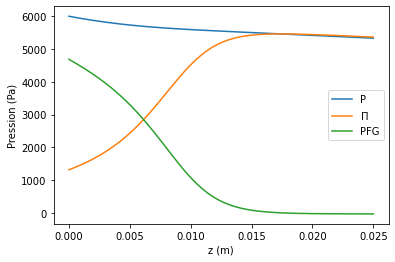

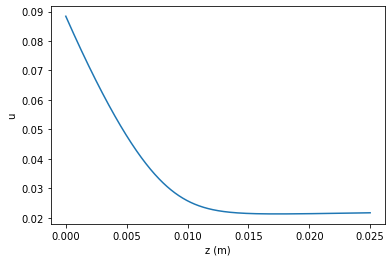

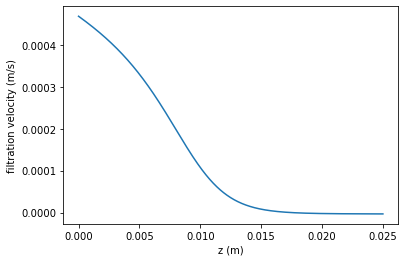

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

k=1.380649e-23
T=298.
N=6.02214076e23

mu=0.001
R=1e-4
K=1e-7
P0=45*133.32237 #45 mmHg
c0=35 #g/L
M=66000 #g/mol
A=1000*N*k*T/M
Q0=10e-6/3600
print (c0/M)
print (A*c0)

#Calcul du Reynolds
rho=1000
u0=Q0/(np.pi*R*R)
print ('Re=', rho*u0*2*R/mu)


k1=8*mu/(np.pi*R**4)
k2=2*np.pi*R*K
k3=A*c0*Q0

def dX_dz(X,z=0):
    return np.array([-k1*X[1], -k2*(X[0]-k3/X[1])])

z=np.linspace(0,0.025,1000)
X0=np.array([P0,Q0])
X,infodict=integrate.odeint(dX_dz,X0,z,full_output=True)

#trace de la pression
plt.plot(z, X[:,0], label='P')
#trace de la pression osmotique
plt.plot(z, k3/X[:,1], label=r'$\Pi$')
#trace de la pression de filtration glomérulaire
plt.plot(z, X[:,0]-k3/X[:,1], label='PFG')
plt.xlabel ('z (m)')
plt.ylabel ('Pression (Pa)')
plt.legend()
plt.show()

#trace de la vitesse axiale
plt.plot(z, X[:,1]/(np.pi*R*R))
plt.xlabel ('z (m)')
plt.ylabel ('u')
plt.show()

#trace de la vitesse de permeation
plt.plot(z, K*(X[:,0]-k3/X[:,1]))
plt.xlabel ('z (m)')
plt.ylabel ('filtration velocity (m/s)')
plt.show()


        

In [5]:
#1 mL en 1 min
Q=1e-6/60
J=100*1e-3/3600 #m/s 100L/hm2
S=Q/J
L=S/(2*3.14*1e-3)
print (L)


0.09554140127388534


In [6]:
#capillaire 4 mm de diamètre interne
R=2e-3
Sect=np.pi*R*R
J=100*1e-3/3600 #m/s 100L/hm2
Q=J*Sect
#V pour L=2cm
L=0.07
V=L*Sect

t=V/Q
print(t)

2520.0
